<a href="https://colab.research.google.com/github/dbabrams/FloPy_Toy_Models/blob/master/CoLabMason.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [126]:
!pip install pyproj
!pip install rasterio
!pip install flopy
!pip install https://github.com/modflowpy/pymake/zipball/master

     | 153kB 811kB/s
  Created wheel for pymake: filename=pymake-1.1.0-cp36-none-any.whl size=38199 sha256=c8d525f330dbfd8078195686f0ee1b1b222cb743f8432fe188ecb25c5d38da5d
  Stored in directory: /tmp/pip-ephem-wheel-cache-omwtjjlp/wheels/4e/91/61/e7ad711088661efc2055f76212317884c2ac12bae66f318fdc
Successfully built pymake


In [2]:
import flopy
import matplotlib as mp
import pandas as pd
import pyproj
import rasterio 
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


flopy is installed in /usr/local/lib/python3.6/dist-packages/flopy


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':"1vQgYEh41Cpx_XcsYnsnsh8zLb6j9RCRy"})   # replace the id with id of file you want to access
downloaded.GetContentFile('dem_ill.tif')

downloaded = drive.CreateFile({'id':"1JsAiGG4RvcfYrQtfgXRW9ZVfAkQ1yRVu"})
downloaded.GetContentFile('rivers_625.csv')

In [127]:
import pymake

def make_mf2005():
    pymake.build_apps('mf2005')

if __name__ == "__main__":
    make_mf2005()

mf2005 will be built for the "linux" operating system

mf2005 will be placed in the directory:
    "."

mf2005 will be built using "single" precision floats.

mf2005 will be built as a "release" application.

mf2005 fortran code will be built with "gfortran".
mf2005 c/c++ code will be built with "gcc".

mf2005 will use the following predefined syslibs:
    -lc

mf2005 will be built for "intel64" architecture.

downloading file:         True
verified download:        True
download timeout:         30 sec.
cleaning extracted files: True

extra files are not being read

Attempting to download the file:
    https://water.usgs.gov/water-resources/software/MODFLOW-2005/MF2005.1_12u.zip
 download attempt: 1
   file size: 6,585,179 bytes
     downloaded   204,800 bytes of 6,585,179 bytes (   3.1100%)
     downloaded   409,600 bytes of 6,585,179 bytes (   6.2200%)
     downloaded   614,400 bytes of 6,585,179 bytes (   9.3300%)
     downloaded   819,200 bytes of 6,585,179 bytes (  12.4401%)
    

In [0]:
!cp mf2005 /usr/local/bin
!chmod 755 /usr/local/bin/mf2005

In [0]:
'''Create a MODFLOW model object and run with MODFLOW 2005.'''
#----------------------------------------------------------------------------
modelname = "my_model"
m = flopy.modflow.Modflow(modelname, exe_name = 'mf2005')
#----------------------------------------------------------------------------

In [137]:
#----------------------------------------------------------------------------
# Define model domain in lat/long coordinates
sw_lat =  40.045872 #southwest latitude
sw_long = -90.397402 #southwest longitude
ne_lat =  40.575944 #northeast latitude
ne_long = -89.587339 #northeast longitude

illimap = {'proj': 'lcc', # Lambert Conformal Conic
     'ellps': 'clrk66',
     'lon_0': -89.5,
     'lat_0': 33,
     'lat_1': 33,
     'lat_2': 45,
     'x_0': 2999994*0.3048,
     'y_0': 0}

prj = pyproj.Proj(illimap)

wgs84 = pyproj.Proj("epsg:4326")

nex, ney = pyproj.transform(wgs84,illimap,ne_lat,ne_long)
swx, swy = pyproj.transform(wgs84,illimap,sw_lat,sw_long)

nex, ney = round(nex/0.3048,-4), round(ney/0.3048,-4)
swx, swy = round(swx/0.3048,-4), round(swy/0.3048,-4)
print(nex,ney,swx,swy)

# Assign Discretization variables
Lx = nex-swx # Width of the model domain
Ly = ney-swy # Height of the model domain
ztop = 0. # Model top elevation
zbot = -50. # Model bottom elevation
nlay = 1 # Number of model layers
dx = 1000
dy = 1000
nrow = int(Ly/dy) # Number of rows
ncol = int(Lx/dx) # Number of columns

nper = 1 #specify number of stress periods
steady = [True] #specify if stress period is transient or steady-state

# create flopy discretization object
# length and time are feet (1) and days (4).
# See https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?dis.htm 
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 1, 
                               nper=nper, steady=steady)

2980000.0 2750000.0 2750000.0 2560000.0


In [0]:
'''Create the Basic Package, which contains ibound and starting heads'''
#----------------------------------------------------------------------------
# Create ibound as array of ints (1), indicating all cells are active
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)

# Create starting head array, must be floats.
strt = 5*np.ones((nlay, nrow, ncol), dtype=np.float32) #set every cell to 5.0

#Create flopy bas object
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=strt)
#----------------------------------------------------------------------------

In [0]:
'''Create the Layer Property Flow Package, which contains information about
hydruaulic conductivity and other information about how to calculate flow'''

hk = np.ones((nlay,nrow,ncol), dtype=np.float32) #define horizontal hydraulic conductivity
vk = np.ones((nlay,nrow,ncol), dtype=np.float32) #define vertical hydraulic conductivity

#define layer type as convertible (1), must be an integer
#for more information, see https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?dis.htm
laytyp = np.ones((nlay,), dtype=np.int32)

# create the LPF object
lpf = flopy.modflow.ModflowLpf(model=m, hk=hk, vka=vk, laytyp=laytyp, ipakcb=1)


In [0]:


rch = flopy.modflow.mfrch.ModflowRch(model=m,rech = 0.00001)


In [0]:
# import stage, lambert x, lambert y
dfriv = pd.read_csv('rivers_625.csv')

# trim dataframe with river information to the model domain
dfriv = dfriv.loc[dfriv['lamx']<nex]
dfriv = dfriv.loc[dfriv['lamy']<ney]
dfriv = dfriv.loc[dfriv['lamx']>swx]
dfriv = dfriv.loc[dfriv['lamy']>swy]

# assign all rivers to the upper layer
dfriv['lay'] = 0
# convert lamx to column and lamy to row
dfriv['row'] = np.trunc((ney-dfriv['lamy'])/dy)
dfriv['col'] = np.trunc((dfriv['lamx']-swx)/dx)
# define the river stage
dfriv['stage'] = dfriv['rvr_stg']
#define the conductance
dfriv['cond'] = 5000. # ft^2/d
# define the river bottom
dfriv['bot'] = dfriv['stage']-3
# drop unneeded files
dfriv = dfriv.drop(['STR_ORD_MI','STR_ORD_MA','SUM_LENGTH','rvr_stg','lamx','lamy'],axis=1)

# put into a format that MODFLOW wants
arriv = dfriv.values
riverdata = {0: arriv}

riv = flopy.modflow.mfriv.ModflowRiv(model=m, ipakcb=None,stress_period_data=riverdata)


In [0]:
#create oc stress period data. 
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
#create output control object
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

In [0]:
'''Create the PCG Solver Object'''
#----------------------------------------------------------------------------
# for the time being, we will use default settings with the solver
pcg = flopy.modflow.ModflowPcg(model=m)
#----------------------------------------------------------------------------

In [0]:
m.write_input()

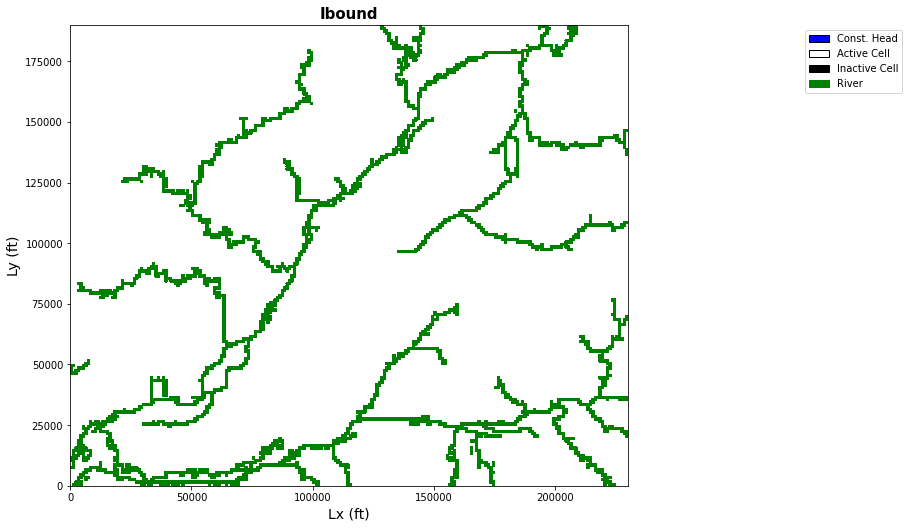

In [145]:
'''Plot grid and boundary conditions'''
#----------------------------------------------------------------------------
plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
#grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
rvr = modelmap.plot_bc(ftype='RIV')
#add labels and legend
plt.xlabel('Lx (ft)',fontsize = 14)
plt.ylabel('Ly (ft)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                   mp.patches.Patch(color='green',label='River',ec='green')],
                   bbox_to_anchor=(1.5,1.0))
#----------------------------------------------------------------------------

In [146]:
# Executve the model run
success, mfoutput = m.run_model(pause=False, report=True)
# Report back if the model did not successfully complete
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following  executable to run the model: /usr/local/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: my_model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/04/07  2:31:26

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/04/07  2:31:27
 Elapsed run time:  0.495 Seconds

  Normal termination of simulation


In [0]:
ildem = rasterio.open('dem_ill.tif')
elev = ildem.read(1)
elev = np.where(elev<0,400,elev)
plt.imshow(elev, cmap='pink')